In [118]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils.make_pairs import make_pairs

## Prepare Data For Siamese Network

Load Data and Labels

In [119]:
# have to choose this img size because of moblie net, that we use as feature extractor
IMG_SHAPE = 96

train_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_train'
val_data_dir = r'C:\Users\jands\Market-1501-v15.09.15\bounding_box_val'

file_paths_train = tf.data.Dataset.list_files(train_data_dir + '/*.jpg')
file_paths_val = tf.data.Dataset.list_files(val_data_dir + '/*.jpg')

# Define the function to extract the label from the file name
# works for my specific directory path...
def extract_label(file_path):
    label = tf.strings.split(file_path, '_')
    label = tf.strings.split(label, '\\')
    return int(label[2][1])

def read_and_decode(file_path):
    label = extract_label(file_path)
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE), method='bicubic')
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print("[INFO] loading data...")

dataset_train = [read_and_decode(file) for file in file_paths_train]
dataset_val = [read_and_decode(file) for file in file_paths_val]

[INFO] loading data...


Visualize Training Data

IMAGE SHAPE:  (96, 96, 3)


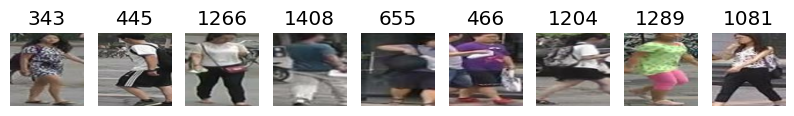

In [120]:
plt.figure(figsize=(10, 10))
subplot_pos = 1

for image, label in dataset_train[:9]:
  ax = plt.subplot(1, 9, subplot_pos)
  subplot_pos += 1
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")

print("IMAGE SHAPE: ", image.shape)

In [121]:
labels = [label for image, label in dataset_train]
unique_labels = np.unique(np.array(labels))

idxs = [np.where(labels == unique_label)[0] for unique_label in unique_labels]

for unique_label in unique_labels:
    idxs = np.where(labels == unique_label)[0]
    print(f"unique label {unique_label} contains {len(idxs)} images")

unique label 1 contains 6 images
unique label 2 contains 46 images
unique label 3 contains 5 images
unique label 4 contains 5 images
unique label 5 contains 6 images
unique label 6 contains 5 images
unique label 7 contains 7 images
unique label 8 contains 3 images
unique label 9 contains 3 images
unique label 10 contains 11 images
unique label 11 contains 15 images
unique label 12 contains 6 images
unique label 13 contains 2 images
unique label 14 contains 3 images
unique label 15 contains 6 images
unique label 16 contains 5 images
unique label 17 contains 3 images
unique label 18 contains 5 images
unique label 19 contains 4 images
unique label 20 contains 6 images
unique label 21 contains 4 images
unique label 22 contains 59 images
unique label 23 contains 20 images
unique label 24 contains 4 images
unique label 25 contains 3 images
unique label 26 contains 4 images
unique label 27 contains 15 images
unique label 28 contains 11 images
unique label 29 contains 4 images
unique label 30 

Make Pairs

In [122]:
train_pair_x, train_pair_y = make_pairs(dataset_train)
val_pair_x, val_pair_y = make_pairs(dataset_val)

[INFO] preparing positive and negative pairs...
[INFO] preparing positive and negative pairs...


c:\Users\jands\Project_Shaman\py_3_9_venv\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


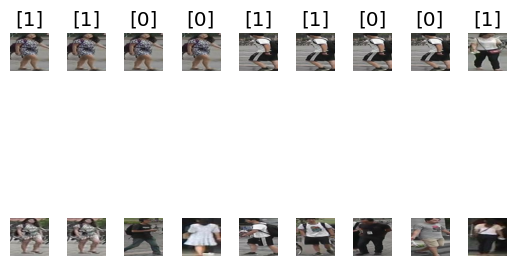

In [123]:
fig, axes = plt.subplots(2, 9)
plt.subplots_adjust(wspace=0.5, hspace=0)
j = 0

for img_1, img_2 in train_pair_x[:9]:
  axes[0, j].imshow(img_1)
  axes[1, j].imshow(img_2)
  axes[0, j].set_title(train_pair_y[j])
  axes[0, j].set_axis_off()
  axes[1, j].set_axis_off()
  j += 1

## Creating Siamese Network

In [124]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential

Choose a Pretrained Model as Feature Extractor

In [125]:
# the image size for all the images in The Market Dataset is 128x64
IMG_SHAPE = (96, 96, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False
global_average_layer = GlobalAveragePooling2D()

feature_extractor = Sequential([base_model, global_average_layer])

In [126]:
feature_extractor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


Create similarity evaluation function

In [127]:
import tensorflow.keras.backend as K

def euclidean_distance(vectors):
	features_1, features_2 = tf.split(vectors, 2, axis=0)
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(features_1 - features_2), axis=1, keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

Configure Siamese Network

In [128]:
print("[INFO] building model...")
img_1 = Input(shape=IMG_SHAPE)
img_2 = Input(shape=IMG_SHAPE)

features_1 = feature_extractor(img_1)
features_2 = feature_extractor(img_2)
distance = Lambda(euclidean_distance)([features_1, features_2])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[img_1, img_2], outputs=outputs)   

[INFO] building model...


In [129]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 1280)         2257984     ['input_16[0][0]',               
                                                                  'input_17[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (1, 1, 1280)         0           ['sequential_4[0][0]',     

## Training Siamese Network

In [130]:
BATCH_SIZE = 32
EPOCHS = 1

tensoboard_dir = r"C:\Users\jands\Project_Shaman\Siamese Network\logs\tensorboard"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensoboard_dir, histogram_freq=1)

# compile the model
print("[INFO] compiling model...")
base_learning_rate = 0.0001
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pair_x[:, 0], train_pair_x[:, 1]], train_pair_y[:],
	validation_data=([val_pair_x[:, 0], val_pair_x[:, 1]], val_pair_y[:]),
	batch_size=BATCH_SIZE, 
	epochs=EPOCHS,
	callbacks=[tensorboard_callback])

[INFO] compiling model...
[INFO] training model...
1906/1906 [==============================] - 746s 378ms/step - loss: 0.9639 - accuracy: 0.4950 - val_loss: 1.0308 - val_accuracy: 0.5000


Visualize Training Data

[INFO] plotting training history...


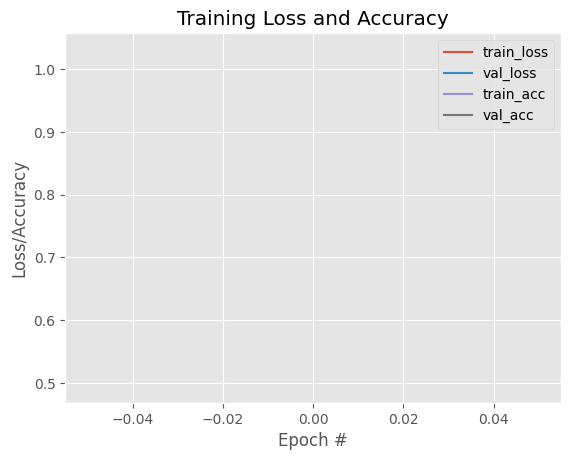

In [131]:
# visualized data from training can be also found in tensorboard
from utils.plot_training import plot_training
path = "logs/training_plot5.png"
print("[INFO] plotting training history...")
plot_training(history, path)

Save Siamese Network Model

In [132]:
model.save("model/siamese_network5.h5")

## Evaluation

Load Model

In [133]:
from tensorflow.keras.models import load_model
model = load_model('model/siamese_network5.h5')

SystemError: Exception encountered when calling layer "lambda_4" (type Lambda).

unknown opcode

Call arguments received by layer "lambda_4" (type Lambda):
  • inputs=['tf.Tensor(shape=(None, 1280), dtype=float32)', 'tf.Tensor(shape=(None, 1280), dtype=float32)']
  • mask=None
  • training=None

In [ ]:
predictions = model.predict([val_pair_x[:40,0], val_pair_x[:40,1]])

2/2 [==============================] - 4s 122ms/step


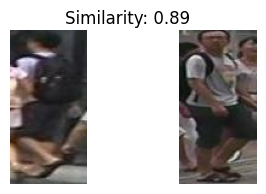

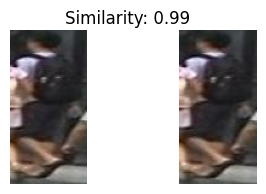

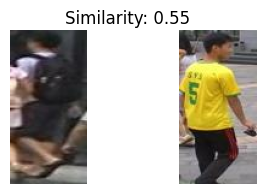

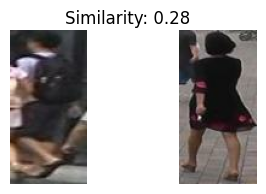

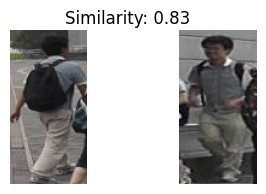

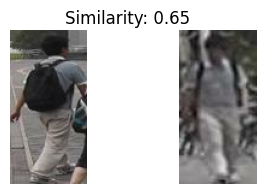

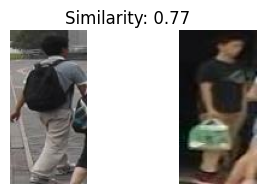

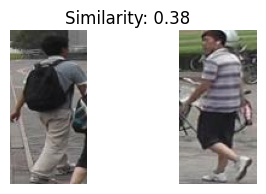

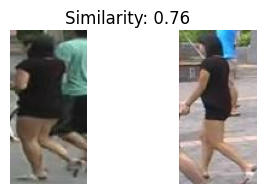

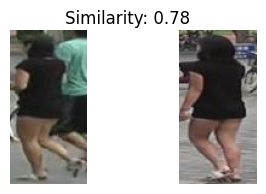

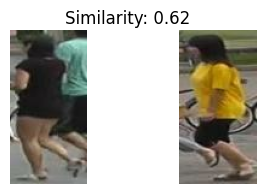

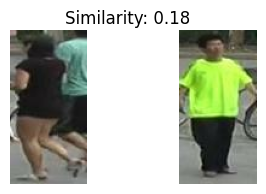

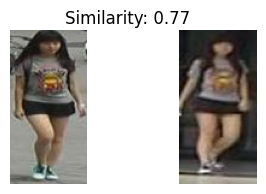

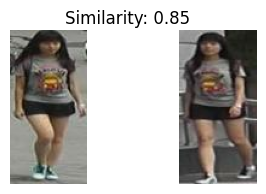

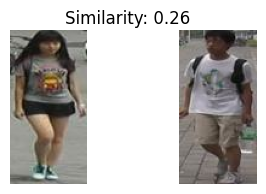

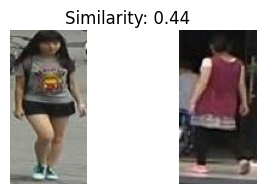

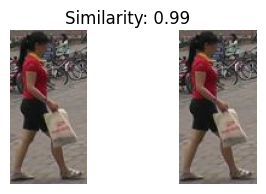

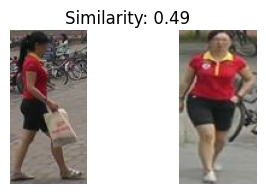

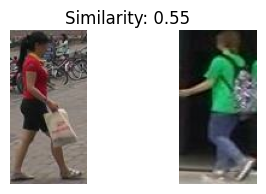

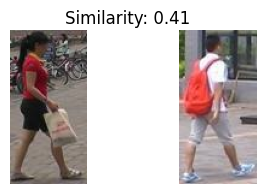

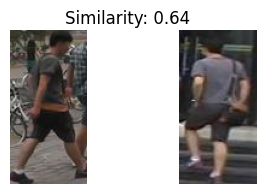

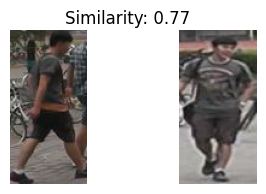

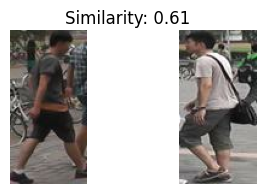

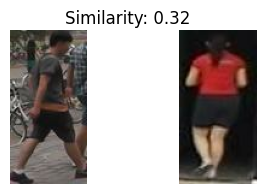

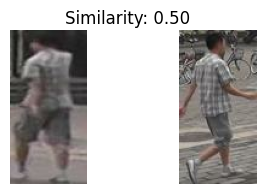

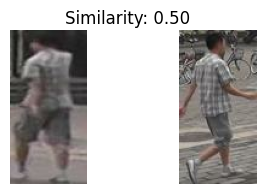

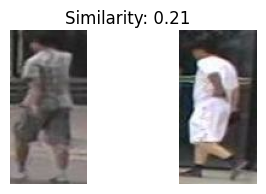

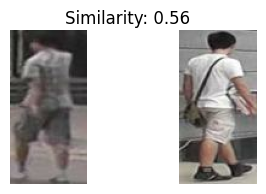

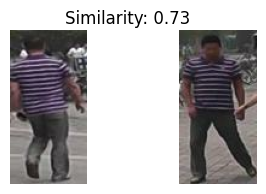

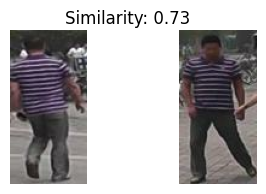

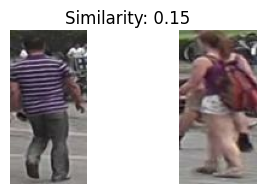

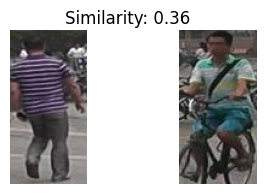

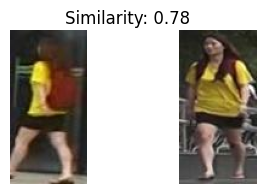

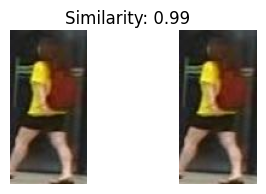

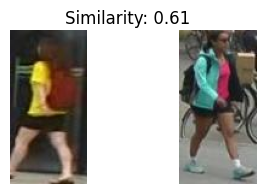

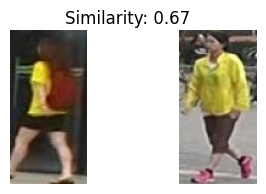

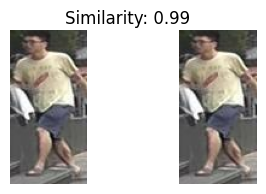

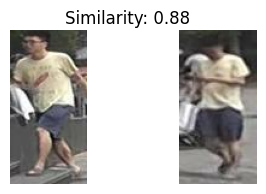

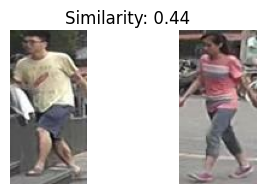

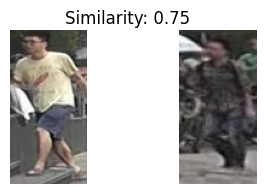

In [ ]:
for i in range(40):
  # initialize the figure
  fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
  plt.suptitle("Similarity: {:.2f}".format(predictions[i][0]))

  ax = fig.add_subplot(1, 2, 1)
  plt.imshow(val_pair_x[i, 0])
  plt.axis("off")

  ax = fig.add_subplot(1, 2, 2)
  plt.imshow(val_pair_x[i, 1])
  plt.axis("off")

  plt.show()